<a href="https://colab.research.google.com/github/187ram/Dog-Breed-Identification-CNN/blob/dev-branch/Dog_Breed_Identification_(Kaggle)_Using_Pretrained_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Totality Corp
## Assignment
**Part 1**

Build a dog breed image classification model with the architecture specified below.

**Dataset** - https://www.kaggle.com/c/dog-breed-identification/data


###Fetching data from kaggle 

In [4]:
#@title
! pip install -q kaggle

In [1]:
#@title
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ram187","key":"d96ee9616c3171544af6a85ef8c9cbc0"}'}

In [5]:
#@title
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
#@title
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
#@title
! kaggle datasets download -d ram187/dog-breed-identification

 98% 674M/691M [00:07<00:00, 106MB/s]
100% 691M/691M [00:07<00:00, 95.8MB/s]


In [49]:
# #@title
# ! unzip /content/dog-breed-identification.zip

# Dog Breed Identification
The classifier only predict scores for these breeds : beagle, chihuahua, doberman,
french_bulldog, golden_retriever, malamute, pug, saint_bernard, scottish_deerhound,
tibetan_mastiff.

# Data Pre-Proccessing

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
from shutil import copyfile
import matplotlib.pyplot as plt
#%matplotlib inline

In [12]:
labels = pd.read_csv('labels.csv')
selected_breed_list = ['beagle', 'chihuahua', 'doberman','french_bulldog', 'golden_retriever', 'malamute', 
                      'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']

labels = labels[labels['breed'].isin(selected_breed_list)]

In [13]:
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]
print(len(images),images[0])

10222 b297a6f06bcc920e872fff4eeec4f9bf.jpg


In [14]:
temp = '.'.join((labels.loc[labels.index[840], 'id'],'jpg'))

In [15]:
new_image = []
for item in range(labels.size//2-1):
    if  '.'.join((labels.loc[labels.index[item], 'id'],'jpg')) in images:
        new_image.append('.'.join((labels.loc[labels.index[item], 'id'],'jpg')))

In [16]:
if  not os.path.exists('training_images'):
        os.makedirs('training_images')

if  not os.path.exists('validation_images'):
    os.makedirs('validation_images')

In [17]:
os.chdir('training_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)
        #os.rmdir(curClass)

os.chdir('../validation_images')
for curClass in classes:    
    if  not os.path.exists(curClass):
        os.makedirs(curClass)

In [18]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in new_image:
    if count >680:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
        copyfile('train/'+item, destination_directory+labels_dict[filekey]+'/'+item)
    #print(labels_dict[filekey])
    count +=1

# Displaying the original image of "Tibetan_Mastiff"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
img = load_img('training_images/tibetan_mastiff/70fe05acafe344e3359dd4742aedbc05.jpg') 
img

##image augmentation for 3 trials of "Tibetan_Mastiff "

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/tibetan_mastiff/70fe05acafe344e3359dd4742aedbc05.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## Displaying the image after image augmentation of "Tibetan_Mastiff "

In [ ]:
img1=load_img('preview/dog_breed_0_6288.jpeg')
img1

In [ ]:
img2=load_img('preview/dog_breed_0_7267.jpeg')
img2

In [ ]:
img3=load_img('preview/dog_breed_0_9294.jpeg')
img3

# Implementing Resnet50 Convolution Neural Network architecture.

In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.utils import layer_utils
from keras import backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

**Import ResNet50 weights trained on ImageNet**

In [20]:
#General idea: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
#The author of this article tried to classify dogs vs cats with a pretrained model and provides an abstract idea 
model = ResNet50(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


##Add 5 hidden layers and an output layer

In [21]:
x = model.output
x = Flatten()(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=750,activation='relu')(x)
x=Dropout(0.25)(x)
x=Dense(units=1000,activation='relu')(x)
x=Dropout(0.6)(x)
predictions = Dense(10, activation='softmax')(x)

In [22]:
import keras
main_model = Model(inputs=model.input, outputs=predictions)
#train only the hidden layers and output layer, donot train the resnet model
for curLayer in model.layers:
    curLayer.trainable = False

main_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
#main_model.summary()

## Image Augmentation

In [23]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(224, 224),
        batch_size=22,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(224, 224),
        batch_size=22,
        class_mode='categorical')

Found 681 images belonging to 10 classes.
Found 159 images belonging to 10 classes.


## Model Fit

In [51]:
hist=main_model.fit(
        training_set,
        steps_per_epoch=30,
        epochs=100,
        validation_data=test_set,
        validation_steps=6,callbacks=callbacks_list)

In [27]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
main_model.save('my_model.h5') 

# Obtain Predictions

In [28]:
import os
import cv2
import pandas as pd
import numpy as np
test_set = []
test_set_ids = []
for curImage in os.listdir('quick_test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('quick_test/'+curImage)
    test_set.append(cv2.resize(curImage,(224, 224)))

In [29]:
test_set = np.array(test_set, np.float32)/255.0

In [ ]:
#test_set.shape

In [30]:
predictions= main_model.predict(test_set)

In [31]:
training_set.class_indices

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}

## Process the Prdictions to an Output File

In [32]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(10)]
column_names

['beagle',
 'chihuahua',
 'doberman',
 'french_bulldog',
 'golden_retriever',
 'malamute',
 'pug',
 'saint_bernard',
 'scottish_deerhound',
 'tibetan_mastiff']

In [33]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
predictions_df.set_index('id',inplace=True)
predictions_df.head()

,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
id,,,,,,,,,,
4f06a97002f941d3b1b7021636c27222,0.121437,0.083941,0.091479,0.080956,0.080701,0.105134,0.107601,0.099222,0.151357,0.078173
4efd18204c98543662580a1874f79d31,0.121437,0.083941,0.091479,0.080956,0.080701,0.105134,0.107601,0.099222,0.151357,0.078173
4f5f35204ad2b401c1d00557a1dec1c3,0.121437,0.083941,0.091479,0.080956,0.080701,0.105134,0.107601,0.099222,0.151357,0.078173
6ce2f79bfc8e23d4158f79d1b2d034d1,0.121437,0.083941,0.091479,0.080956,0.080701,0.105134,0.107601,0.099222,0.151357,0.078173
4ef2b99d3028844d067feda58dc5f1f0,0.121437,0.083941,0.091479,0.080956,0.080701,0.105134,0.107601,0.099222,0.151357,0.078173


In [ ]:
predictions_df.to_csv('final_submission.csv',sep=",")

In [ ]:
print(hist.history)

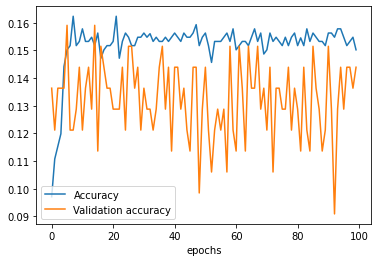

In [25]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

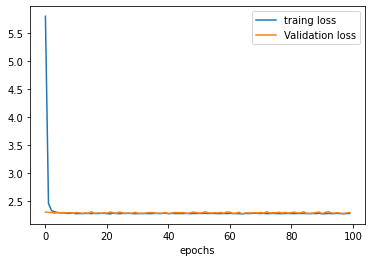

In [26]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

# Evaluation metrics

In [42]:
validation_generator = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(244, 244),
        batch_size=22,
        class_mode='categorical',
        shuffle=False)

Found 159 images belonging to 10 classes.


In [43]:
y_true = validation_generator.classes
print(y_true.shape,y_pred.shape)

(159,) (159,)


In [45]:
Y_pred = model.predict(validation_generator, 6) #num_of_test_samples // batch_size+1
y_pred = np.argmax(np.argmax(np.argmax(Y_pred, axis = 1), axis = 1), axis=1)

## Accuracy

In [41]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))


Accuracy: 0.07



## Confusion_matrix

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

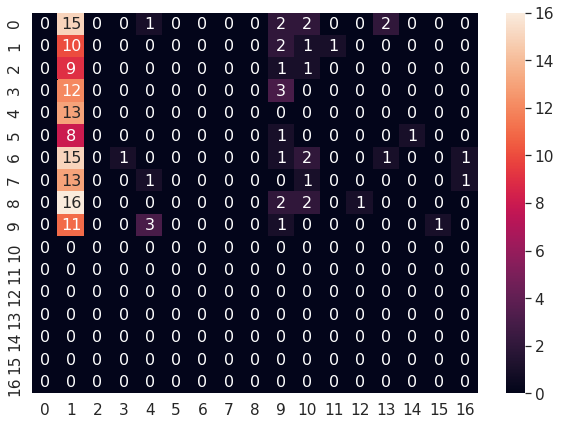

In [46]:
array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(17), range(17))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## F1 Score

In [48]:
print(classification_report(y_true, y_pred,))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.08      0.71      0.15        14
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        21
           9       0.08      0.06      0.07        16
          11       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         0
          37       0.00      0.00      0.00         0
          50       0.00      0.00      0.00         0
          60       0.00      0.00      0.00         0
          65       0.00      0.00      0.00         0

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
